In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Project 2

### Generative AI
### Jack Bosco
### Working with GANS

---

1. ### Dataset Preparation 

	- Download and load the Fashion-MNIST dataset using `torchvision.datasets.FashionMNIST`
	- Normalize the images to have values between -1 and 1, as this range typically works well with the ReLU activation function used in the generator's layers.
	- Create DataLoader objects for the training dataset to iterate over batches.

In [2]:
# define the transforms to values between -1 and 1
transform = transforms.Compose(
	[
		transforms.ToTensor()
		, transforms.Normalize((.5), (.5), inplace=True) # normalize between -1 and 1
  	]
)

batchsize = 6

# load the training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False, num_workers=2)

# define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Visualize the data

torch.Size([6, 1, 28, 28]) torch.Size([6])
tensor(-1.) tensor(1.)


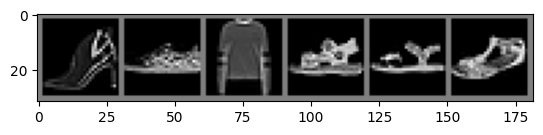

|   Ankle boot    |     Sneaker     |    Pullover     |     Sandal      |     Sandal      |     Sandal      |


In [3]:
# print some info about a sample from the data
e = next(iter(trainloader))
print(e[0].shape, e[1].shape)
print(e[0].min(), e[0].max())

# show some images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
	img = img / 2 + 0.5 # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

imshow(torchvision.utils.make_grid(e[0]))
s = '|' + r'{:^17s}|' * batchsize
print(s.format(*[classes[e[1][j]] for j in range(batchsize)]))

### 2. Make the GAN Archetecture

The generator uses batch normalization `BatchNorm1d` to stabilize training.

The discriminator uses `LeakyReLU` activations to prevent gradients from vanishing.

In [4]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#dev = torch.device('cpu')

In [5]:
# Generator Model
class Generator(nn.Module):
	def __init__(self, latent_dim, img_shape):
		super(Generator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(128, 256),
			nn.BatchNorm1d(256, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 512),
			nn.BatchNorm1d(512, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 1024),
			nn.BatchNorm1d(1024, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(1024, int(np.prod(img_shape))),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		img = img.view(img.size(0), *img_shape)
		return img

# Discriminator Model
class Discriminator(nn.Module):
	def __init__(self, img_shape):
		super(Discriminator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(int(np.prod(img_shape)), 512),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 256),
			nn.ReLU(inplace=True),
			nn.Linear(256, 1),
			nn.Sigmoid()
		)

	def forward(self, img):
		img_flat = img.view(img.size(0), -1)
		validity = self.model(img_flat)
		return validity

# Initialize the models
latent_dim = 100 # Size of the latent vector (input noise)
img_shape = (1, 28, 28) # Fashion-MNIST images are 28x28 pixels in grayscale

generator = Generator(latent_dim=latent_dim, img_shape=img_shape).to(dev)
discriminator = Discriminator(img_shape).to(dev)

# Loss function and optimizer
loss_fn = nn.BCELoss() # Binary cross entropy loss
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.995), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.995))

### 4. Training Loop

- For each epoch, iterate over the DataLoader of the training dataset.

- For each batch, perform the following steps:

- Maximize the log probability of correctly classifying both real and generated images.

- Update the generator to minimize the log probability of the discriminator being correct (i.e., encourage it to generate better fakes).

- Save model checkpoints at regular intervals.

Epoch 1/25, Batch 5000/10000, G Loss: 0.970, D Loss: 0.505
Epoch 1/25, Batch 10000/10000, G Loss: 0.892, D Loss: 0.639
Generated Images


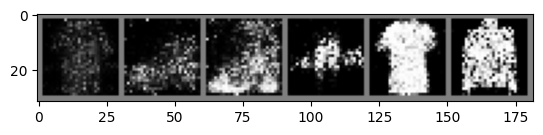

Epoch 2/25, Batch 5000/10000, G Loss: 0.869, D Loss: 0.623
Epoch 2/25, Batch 10000/10000, G Loss: 0.737, D Loss: 0.654
Generated Images


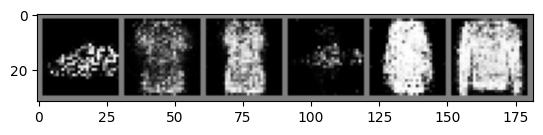

Epoch 3/25, Batch 5000/10000, G Loss: 0.872, D Loss: 0.706
Epoch 3/25, Batch 10000/10000, G Loss: 1.033, D Loss: 0.528
Generated Images


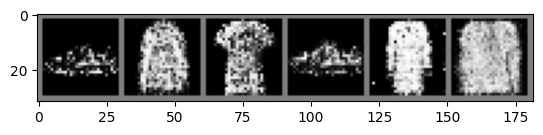

Epoch 4/25, Batch 5000/10000, G Loss: 0.868, D Loss: 0.656
Epoch 4/25, Batch 10000/10000, G Loss: 0.723, D Loss: 0.641
Generated Images


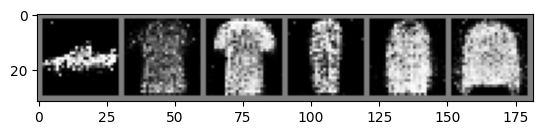

Epoch 5/25, Batch 5000/10000, G Loss: 0.956, D Loss: 0.666
Epoch 5/25, Batch 10000/10000, G Loss: 0.949, D Loss: 0.606
Generated Images


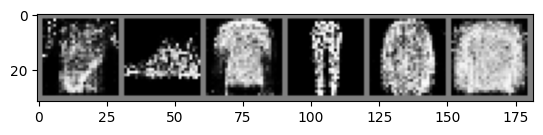

Epoch 6/25, Batch 5000/10000, G Loss: 1.105, D Loss: 0.458
Epoch 6/25, Batch 10000/10000, G Loss: 1.065, D Loss: 0.557
Generated Images


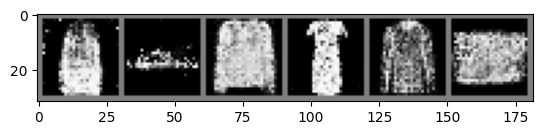

Epoch 7/25, Batch 5000/10000, G Loss: 0.967, D Loss: 0.662
Epoch 7/25, Batch 10000/10000, G Loss: 0.902, D Loss: 0.531
Generated Images


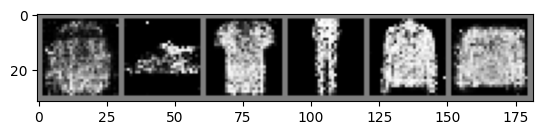

Epoch 8/25, Batch 5000/10000, G Loss: 1.250, D Loss: 0.646
Epoch 8/25, Batch 10000/10000, G Loss: 0.823, D Loss: 0.676
Generated Images


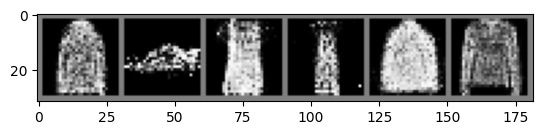

Epoch 9/25, Batch 5000/10000, G Loss: 0.991, D Loss: 0.530
Epoch 9/25, Batch 10000/10000, G Loss: 0.958, D Loss: 0.534
Generated Images


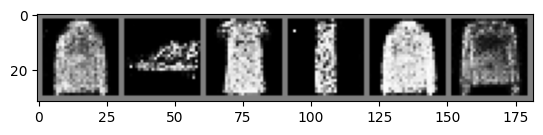

Epoch 10/25, Batch 5000/10000, G Loss: 1.262, D Loss: 0.589
Epoch 10/25, Batch 10000/10000, G Loss: 1.003, D Loss: 0.731
Generated Images


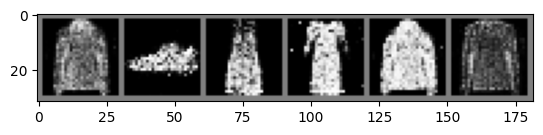

Epoch 11/25, Batch 5000/10000, G Loss: 0.706, D Loss: 0.853
Epoch 11/25, Batch 10000/10000, G Loss: 1.024, D Loss: 0.649
Generated Images


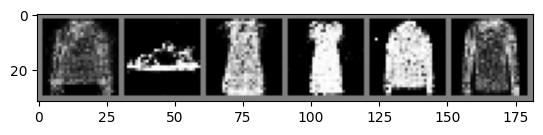

Epoch 12/25, Batch 5000/10000, G Loss: 1.174, D Loss: 0.530
Epoch 12/25, Batch 10000/10000, G Loss: 1.234, D Loss: 0.766
Generated Images


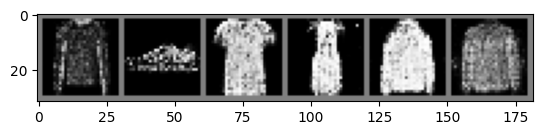

Epoch 13/25, Batch 5000/10000, G Loss: 1.008, D Loss: 0.504
Epoch 13/25, Batch 10000/10000, G Loss: 1.072, D Loss: 0.522
Generated Images


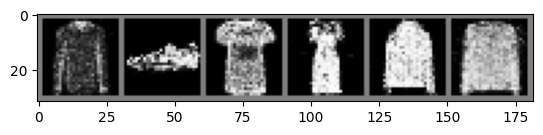

Epoch 14/25, Batch 5000/10000, G Loss: 0.915, D Loss: 0.570
Epoch 14/25, Batch 10000/10000, G Loss: 1.116, D Loss: 0.679
Generated Images


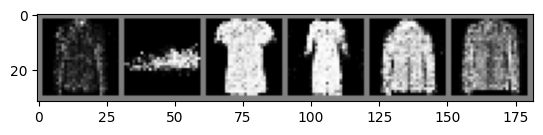

Epoch 15/25, Batch 5000/10000, G Loss: 1.182, D Loss: 0.449
Epoch 15/25, Batch 10000/10000, G Loss: 0.890, D Loss: 0.598
Generated Images


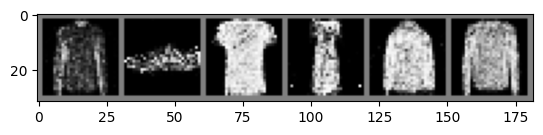

Epoch 16/25, Batch 5000/10000, G Loss: 1.049, D Loss: 0.607
Epoch 16/25, Batch 10000/10000, G Loss: 1.073, D Loss: 0.465
Generated Images


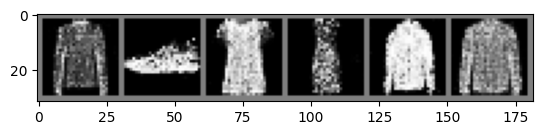

Epoch 17/25, Batch 5000/10000, G Loss: 0.965, D Loss: 0.708
Epoch 17/25, Batch 10000/10000, G Loss: 1.069, D Loss: 0.626
Generated Images


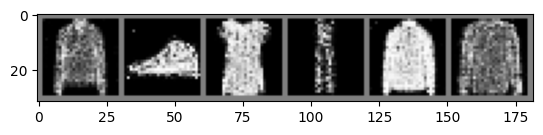

Epoch 18/25, Batch 5000/10000, G Loss: 1.117, D Loss: 0.488
Epoch 18/25, Batch 10000/10000, G Loss: 1.033, D Loss: 0.513
Generated Images


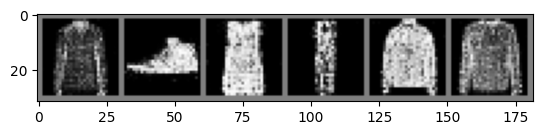

Epoch 19/25, Batch 5000/10000, G Loss: 0.975, D Loss: 0.720
Epoch 19/25, Batch 10000/10000, G Loss: 1.045, D Loss: 0.589
Generated Images


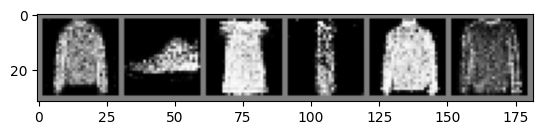

Epoch 20/25, Batch 5000/10000, G Loss: 0.972, D Loss: 0.541
Epoch 20/25, Batch 10000/10000, G Loss: 1.203, D Loss: 0.624
Generated Images


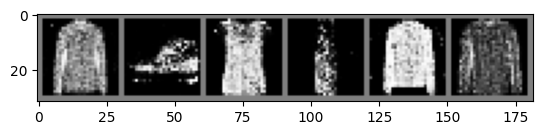

Epoch 21/25, Batch 5000/10000, G Loss: 1.175, D Loss: 0.519
Epoch 21/25, Batch 10000/10000, G Loss: 1.284, D Loss: 0.431
Generated Images


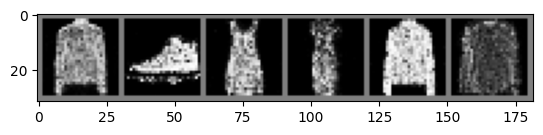

Epoch 22/25, Batch 5000/10000, G Loss: 1.365, D Loss: 0.458
Epoch 22/25, Batch 10000/10000, G Loss: 1.323, D Loss: 0.512
Generated Images


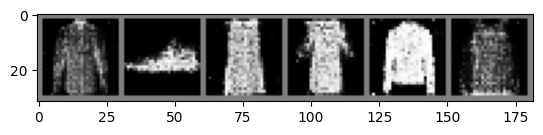

Epoch 23/25, Batch 5000/10000, G Loss: 0.905, D Loss: 0.874
Epoch 23/25, Batch 10000/10000, G Loss: 1.063, D Loss: 0.623
Generated Images


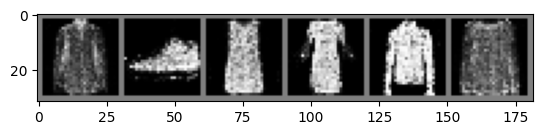

Epoch 24/25, Batch 5000/10000, G Loss: 1.005, D Loss: 0.437
Epoch 24/25, Batch 10000/10000, G Loss: 1.179, D Loss: 0.556
Generated Images


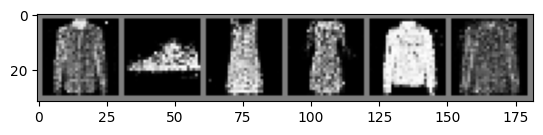

Epoch 25/25, Batch 5000/10000, G Loss: 0.885, D Loss: 0.680
Epoch 25/25, Batch 10000/10000, G Loss: 1.193, D Loss: 0.561
Generated Images


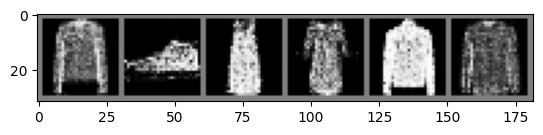

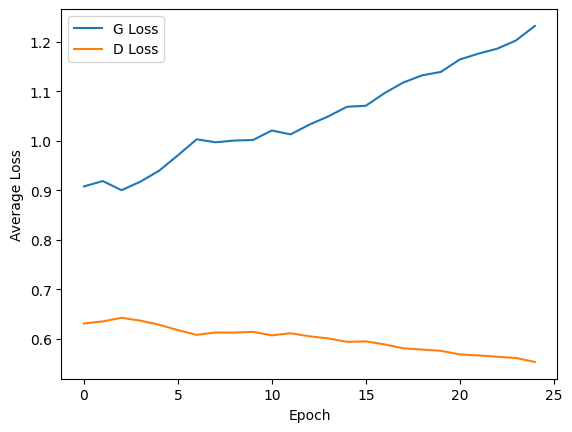

In [6]:
def train(dataloader, epochs, batchsize, latent_dim):
	z_show = torch.randn(batchsize, latent_dim).to(dev) # fixed sample noise for visualization
	avg_loss = {'G Loss': [], 'D Loss': []}
	for epoch in range(epochs): #loop over the dataset for each epoch
		running_loss = {'G Loss': [], 'D Loss': []}
		for i, (imgs, labels) in enumerate(dataloader): #loop for each batch
			valid = torch.ones(batchsize, 1).to(dev)
			fake = torch.zeros(batchsize, 1).to(dev)

			# generate some images
			z = torch.randn(batchsize, latent_dim).to(dev) # Sample noise as generator input
			gen_imgs = generator(z)

			# Train Discriminator
			optimizer_D.zero_grad()
			both = torch.cat((imgs.to(dev), gen_imgs.detach()), 0)
			both_loss = loss_fn(discriminator(both), torch.cat((valid, fake), 0))
			both_loss.backward()
			optimizer_D.step()

			# Train Generator
			optimizer_G.zero_grad()
			y = discriminator(gen_imgs).to(dev)
			g_loss = loss_fn(y, valid)
			g_loss.backward()
			optimizer_G.step()
		
			# save the losses
			running_loss['G Loss'].append(g_loss.item())
			running_loss['D Loss'].append(both_loss.item())
			if (i+1) % 5000 == 0:
				print(f'Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, G Loss: {g_loss.item():.3f}, D Loss: {both_loss.item():.3f}')
		# print generated images
		avg_loss['G Loss'].append(sum(running_loss['G Loss']) / len(running_loss['G Loss']))
		avg_loss['D Loss'].append(sum(running_loss['D Loss']) / len(running_loss['D Loss']))
		gen_imgs = generator(z_show)
		print('Generated Images')
		imshow(torchvision.utils.make_grid(gen_imgs.cpu().detach()))

	loss_df = pd.DataFrame(avg_loss)
	plt.plot(loss_df['G Loss'], label='G Loss')
	plt.plot(loss_df['D Loss'], label='D Loss')
	plt.legend()
	plt.ylabel('Average Loss')
	plt.xlabel('Epoch')
	plt.show()
	plt.savefig('loss.jpeg')
	plt.close()
	

train(trainloader, 25, batchsize, latent_dim)

In [ ]:
#save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')